# Imports and setting up the code

In [1]:
%matplotlib notebook

In [2]:
# %gui qt
# %matplotlib qt

import sys
import os
import time
import logging
from importlib import reload
import numpy as np
from matplotlib import pyplot as plt

import broadbean as bb
# from qdev_wrappers.logger import start_logging
# pvlogger = logging.getLogger('pyvisa')
# pvlogger.setLevel(logging.INFO)
# start_logging()


In [3]:
import qcodes as qc
import broadbean as bb
from broadbean.plotting import plotter
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id

User schema at C:\Users\Jens/qcodesrc_schema.json not found.User settings won't be validated


In [4]:
from pytopo.mplplots import init_nb_plotting; reload(init_nb_plotting)
from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots as mplplots

In [5]:
from pytopo.qctools import instruments as instools; reload(instools)
from pytopo.qctools.instruments import create_inst, add2station
from pytopo.qctools.dataset2 import select_experiment
from pytopo.qctools.measurement import MeasurementExt

from pytopo.rf import alazar_detector; reload(alazar_detector)
from pytopo.rf.alazar_detector import AlazarDetector

from plottr import qcodes_dataset; reload(qcodes_dataset)
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from cqed import broadbean; reload(broadbean)
from cqed.broadbean import BroadBeanSequence, BluePrints

from cqed import bb_sequences; reload(bb_sequences)
from cqed.bb_sequences import TriggeredReadoutSequence, TwoToneSSBSequence

In this notebook we investigate speeding up the performance of a CW experiment as defined in `LK2 cQED.ipynb` We make a few modifications to allow us to only use one rf source and use an Alazar 9360 card as opposed to the Alaar9870. Benchmarking has shown that the Alazar is rather slow in setting up and tearing down a measurement. In the original example a short experiment is repeated 151 times. We improve that by rewriting the example to only do one acquisition from the Alazar. This is possible because the Alazar has two level triggering system.

# Initialize

## Global settings

In [6]:
SAMPLE = 'wrapgate_transmon_no1'

In [7]:
qc.config['core']['db_location'] = "experiments.db"
qc.dataset.database.initialise_database()

## Init instruments

In addition to the standard instruments we define a subclass of the Alazar which has the additional feature that it steps the Microwave source and sends a trigger to the awg. This allows us to capture a buffer for each rf frequency eliminating the overhead of multiple Alazar sessions. The cost of setting up a new Alazar capture is approx 100 ms (ATS 9360) primarily due to the cost of calling `AlazarBeforeAsyncRead` and `AlazarAbortAsyncRead` which are unavoidable within an Alazar session.

In [8]:
inst_list = []

# Alazar
from qcodes.instrument_drivers.AlazarTech import utils; reload(utils)
from qcodes.instrument_drivers.AlazarTech import ATS9360; reload(ATS9360)
from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar', force_new_instance=True)
inst_list.append(alazar)

# Alazar aquisition controllers
from pytopo.rf import alazar_acquisition; reload(alazar_acquisition)
from pytopo.rf.alazar_acquisition import RawAcqCtl, AvgDemodCtl, AvgIQCtl, AvgRecIQCtl, AvgRecCtl, RawAcqCtl, AvgRecDemodCtl, AvgRecIQCtl

class StepperMixin():
    tosweep = np.linspace(5.535e9, 5.585e9, 151)
    
    def _perform_step(self, num):
        """
        First set the RF frequency and then wait to stabilize before
        starting the next buffer with a software trigger to the AWG
        """
        awg = qc.station.Station.default.awg
        LO  = qc.station.Station.default.LO
        while awg.get_state() == 'Running':
            # wait for awg to be done before starting
            # a new seqence
            pass
        LO.frequency(self.tosweep[num])
        time.sleep(0.01)
        awg.force_trigger()

    def pre_acquire(self):
        """
        In pre_acquire we want to start the first two measurements
        
        We need to run two as it seems like we cannot do a dma transfer
        before completing 2 buffers as AlazarWaitAsyncBufferComplete does
        not return until the second buffer is complete. This does not 
        seem to be documented anywhere but has been observed with the latest
        drivers and firmware of the Alazar 9360. (fw 21.06 and driver 06.01.02)
        
        It is not known if this is needed for the Alazar 9870
        """
        super().pre_acquire()
        self._perform_step(0)
        self._perform_step(1)
        
    def buffer_done_callback(self, buffernum):
        """
        When a buffer is complete we want to start the next 
        measurement.
        
        As we are doing this for the next buffer and have
        already completed the first two buffers at the first callback
        we need to add 2 to the counter. We also don't
        want to perform the step for the final buffer as it is already
        complete.
        """

        nextstep = buffernum+2
        if nextstep < len(self.tosweep):
            self._perform_step(nextstep)

# Define subclasses of all the controllers we are using 
# that implement this feature.
class RawAcqCtlWithStepper(StepperMixin, RawAcqCtl):
    pass

class AvgRecCtlWithStepper(StepperMixin, AvgRecCtl):
    pass

class AvgRecDemodCtlWithStepper(StepperMixin, AvgRecDemodCtl):
    pass

class AvgRecIQCtlWithStepper(StepperMixin, AvgRecIQCtl):
    pass



# RF sources
from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::192.168.15.103::inst0::INSTR", force_new_instance=True)
inst_list.append(LO)

# AWG and sequences
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg = instools.create_inst(Tektronix_AWG5014, 'awg', address='TCPIP0::192.168.15.107::inst0::INSTR', force_new_instance=True)
inst_list.append(awg)

# Alazar controllers
raw_acq = instools.create_inst(RawAcqCtlWithStepper, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

avg_acq = instools.create_inst(AvgRecCtlWithStepper, 'avg_acq', 'alazar', force_new_instance=True)
inst_list.append(avg_acq)

avgdem_acq = instools.create_inst(AvgRecDemodCtlWithStepper, 'avgdem_acq', 'alazar', force_new_instance=True)
inst_list.append(avgdem_acq)

avgiq_acq = instools.create_inst(AvgRecIQCtlWithStepper, 'avgiq_acq', 'alazar', force_new_instance=True)
inst_list.append(avgiq_acq)


station = qc.Station(*inst_list)

Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/103873, firmware:3.1.19.15-3.50.124.67) in 0.31s
Connected to: TEKTRONIX AWG5014C (serial:B051039, firmware:SCPI:99.0 FW:4.6.0.7) in 0.04s


## Default (instrument) settings

We use `aux_in_trigger_enable` here for the Alazar. This means that the Alazar will listen for a trigger enable event on the aux port. Once received the Alazar will listen for `records_per_buffer` triggers using the regular trigger. In this case the `External` trigger input. In the following we expect that marker1 of ch1 of the awg is connected to trigger_in on the Alazar and that marker2 is connected to aux_io on the alazar. For this reference experiment we connect the output of the awg directly to ch1 input of the alazar.

In [9]:
with alazar.syncing():
    alazar.clock_source('INTERNAL_CLOCK')
    alazar.sample_rate(200_000_000)
    alazar.clock_edge('CLOCK_EDGE_RISING')
    alazar.decimation(0)
    alazar.coupling1('DC')
    alazar.coupling2('DC')
    alazar.channel_range1(0.4)
    alazar.channel_range2(0.4)
    alazar.impedance1(50)
    alazar.impedance2(50)
    alazar.trigger_source1('EXTERNAL')
    alazar.trigger_level1(128 + 5)
    alazar.external_trigger_coupling('DC')
    alazar.external_trigger_range('ETR_TTL')
    alazar.trigger_delay(16)
    alazar.timeout_ticks(0)
    alazar.aux_io_mode('AUX_IN_TRIGGER_ENABLE')
    #alazar.aux_io_mode('AUX_IN_AUXILIARY')
    alazar.aux_io_param('TRIG_SLOPE_POSITIVE')
    alazar.records_per_buffer(20)
    alazar.buffers_per_acquisition(151)
    alazar.buffer_timeout(10000)
    alazar.samples_per_record(9984)
    alazar.allocated_buffers(2)



# Spectroscopy

## broadbean sequence

In [10]:
ramp = bb.PulseAtoms.ramp
sine = bb.PulseAtoms.sine

Here we define a Broadbean sequence consisting of a squarewave trigger on marker 2 followed by n_rep triggers on marker1 and a sine wave on the analog output. To make it possible to differentiate between different buffers we repeat this sequence with a second set of elements with the sine wave frequenci shifted. Before the trigger on marker2 the awg is programmed to wait for an external (software) trigger. As stated above we will send this once we have captured a buffer and changed the rf frequency.

In [11]:
# alternative sequence to make it easier to test that we are
# seperating and demodulating the signals correctly

SR = 1e9
# voltage level
lvl = 50e-3  # V

# repetitions
n_rep = 20

# define relevant time scales
pre_trig_time = 1e-6
pulse_time = 50e-6
cycle_time = 110e-6
low_time = cycle_time - pulse_time - pre_trig_time


# buffer trigge
buffer_trigger = bb.Element()
buffer_trigger_ch1 = bb.BluePrint()
buffer_trigger_ch1.setSR(SR)
buffer_trigger_ch1.insertSegment(0, ramp, (0, 0), dur=300e-9)
buffer_trigger_ch1.marker2 = [(10e-9, 290-9)]
buffer_trigger.addBluePrint(1, buffer_trigger_ch1)

# element to play waveform and trigger records
rec_trigger = bb.Element()
rec_trigger_ch1 = bb.BluePrint()
rec_trigger_ch1.setSR(SR)
rec_trigger_ch1.insertSegment(0, ramp, (0, 0), dur=pre_trig_time)
rec_trigger_ch1.insertSegment(1, sine, (1e6, lvl, 0, 0), name='pulse', dur=pulse_time)
rec_trigger_ch1.insertSegment(2, ramp, (0, 0), dur=low_time)
rec_trigger_ch1.setSegmentMarker('pulse', (0, pulse_time), 1)
rec_trigger.addBluePrint(1, rec_trigger_ch1)


rec_trigger2 = bb.Element()
rec_trigger2_ch1 = bb.BluePrint()
rec_trigger2_ch1.setSR(SR)
rec_trigger2_ch1.insertSegment(0, ramp, (0, 0), dur=pre_trig_time)
rec_trigger2_ch1.insertSegment(1, sine, (1.5e6, lvl, 0, 0), name='pulse', dur=pulse_time)
rec_trigger2_ch1.insertSegment(2, ramp, (0, 0), dur=low_time)
rec_trigger2_ch1.setSegmentMarker('pulse', (0, pulse_time), 1)
rec_trigger2.addBluePrint(1, rec_trigger2_ch1)

seq = bb.Sequence()
seq.addElement(1, buffer_trigger)
seq.addElement(2, rec_trigger)
seq.addElement(3, buffer_trigger)
seq.addElement(4, rec_trigger2)


seq.setSR(SR)
# wait before starting to sync
seq.setSequencingTriggerWait(1, 1)
# wait after seq while we step external seq
#seq.setSequencingTriggerWait(5, 1)

seq.setSequencingGoto(4, 1)
seq.setSequencingNumberOfRepetitions(2, n_rep)
seq.setSequencingNumberOfRepetitions(4, n_rep)
seq.setChannelAmplitude(1, 1)
seq.setChannelOffset(1, 0)

package = seq.outputForAWGFile()
awgfile = awg.make_awg_file(*package[:])
awg.make_send_and_load_awg_file(*package[:])

awg.ch1_m2_low(0)
awg.ch1_m2_high(2.7)
awg.ch1_state(1)
awg.clock_freq(SR)
awg.run()

'Waiting for trigger'

In [12]:
from broadbean import plotting

<IPython.core.display.Javascript object>


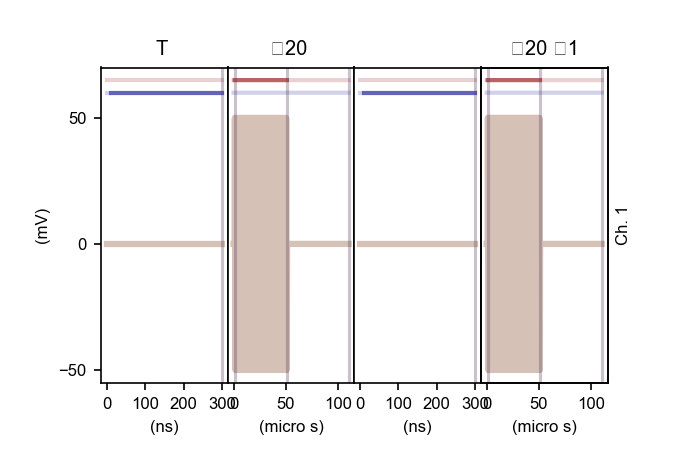

In [13]:
plotting.plotter(seq)

## Testing the new acq

First we perform a capture with a simple controller that returns the data as is while only averaging over records.

In [16]:
%%time
data = avg_acq.acquisition()

Wall time: 3.27 s


In [17]:
print(data.shape)

(151, 9984, 2)


Out of this time more than half (0.01 s *151 = 1.51 s) is spent waiting after setting the rf frequencies and the time used to play the AWG sequences is (110e-6 s *20*151) = 0.33 s.

Looking at the data odd and even buffers we can see the shift in frequencies

<IPython.core.display.Javascript object>


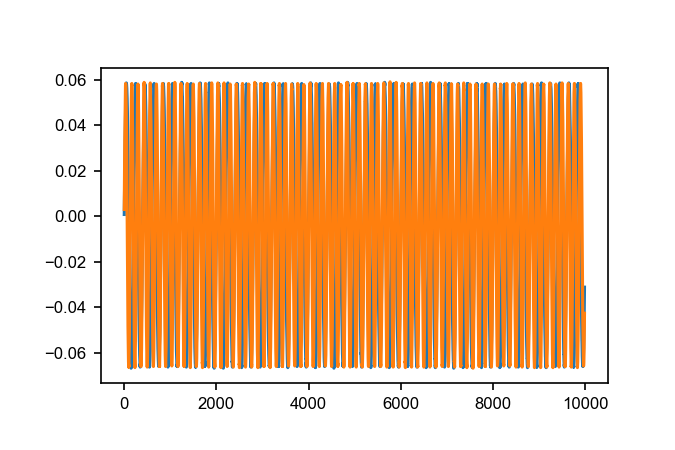

In [18]:
fig, ax = plt.subplots(1,1)

ax.plot(data[0,:,0])
ax.plot(data[1,:,0])


Now lets demodulate the signal. First at 1 freq and then at the other

In [19]:
%%time
avgdem_acq.demod_frq(1.0e6)
data = avgdem_acq.acquisition()

Wall time: 3.4 s


<IPython.core.display.Javascript object>


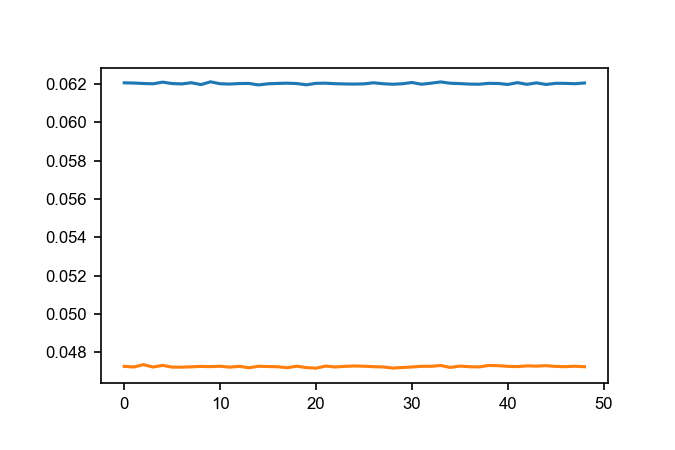

In [20]:
avgdem_acq.demod_frq(1.0e6)
data = avgdem_acq.acquisition()
i = 0
fig, ax = plt.subplots(1,1)
ax.plot(abs(data[0+2*i,:,0]))
ax.plot(abs(data[1+2*i,:,0]))

In [21]:
print(data.shape)

(151, 49, 2)


<IPython.core.display.Javascript object>


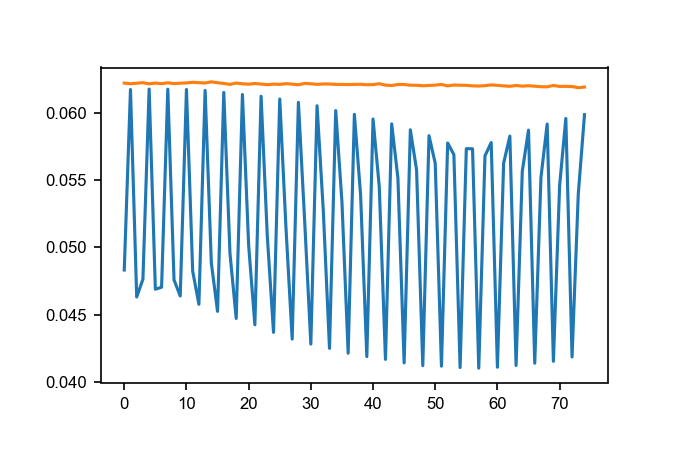

In [22]:
avgdem_acq.demod_frq(1.5e6)
data = avgdem_acq.acquisition()
i = 0
fig, ax = plt.subplots(1,1)
ax.plot(abs(data[0+2*i,:,0]))
ax.plot(abs(data[1+2*i,:,0]))

Then finally we can capture the averaged demodulated signal.

In [24]:
avgiq_acq.demod_frq(1.0e6)
data = avgiq_acq.acquisition()
print(data.shape)

(151, 2)


<IPython.core.display.Javascript object>


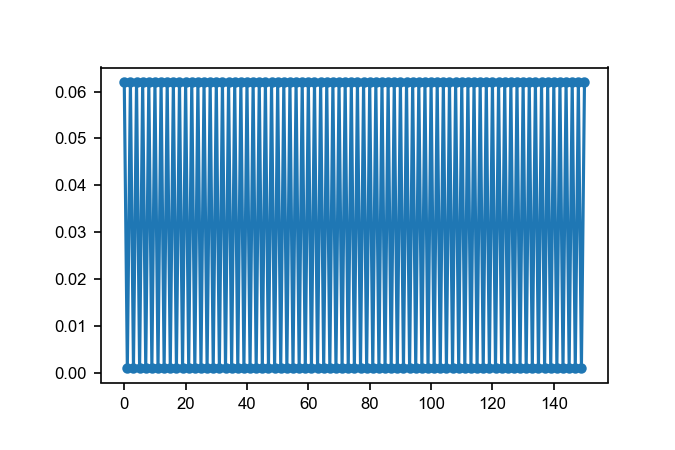

In [25]:
fig, ax = plt.subplots(1,1)
ax.plot(abs(data[:,0]), '-o')

In [26]:
avgiq_acq.demod_frq(1.5e6)
data = avgiq_acq.acquisition()

<IPython.core.display.Javascript object>


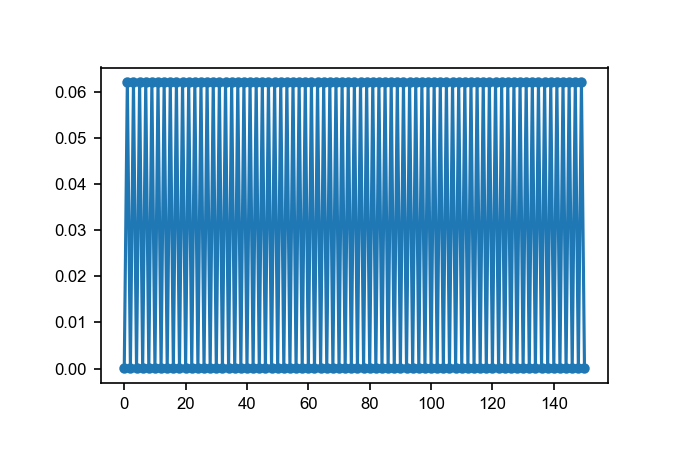

In [27]:
fig, ax = plt.subplots(1,1)
ax.plot(abs(data[:,0]), '-o')

Now lets try to do this in a real measurement

In [28]:
meas = Measurement()
meas.register_parameter(LO.frequency)
meas.register_custom_parameter('I', setpoints=(LO.frequency,))
meas.register_custom_parameter('Q', setpoints=(LO.frequency,))

rf_freqs = np.linspace(5.535e9, 5.585e9, 151)

avgiq_acq.tosweep = rf_freqs
with meas.run() as datasaver:
    avgiq_acq.demod_frq(1.5e6)
    data = avgiq_acq.acquisition()
    datasaver.add_result((LO.frequency, rf_freqs), 
                         ('I', np.real(data[:,0].squeeze())),
                         ('Q', np.imag(data[:,0].squeeze())))
                                            
    run_id = datasaver.run_id


Starting experimental run with id: 21


<IPython.core.display.Javascript object>


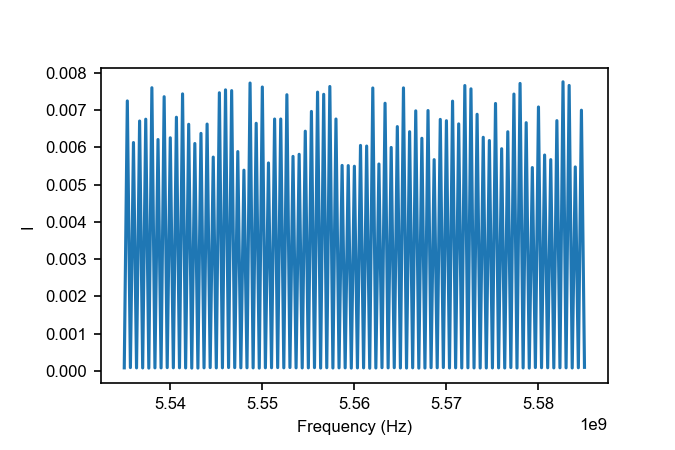

<IPython.core.display.Javascript object>


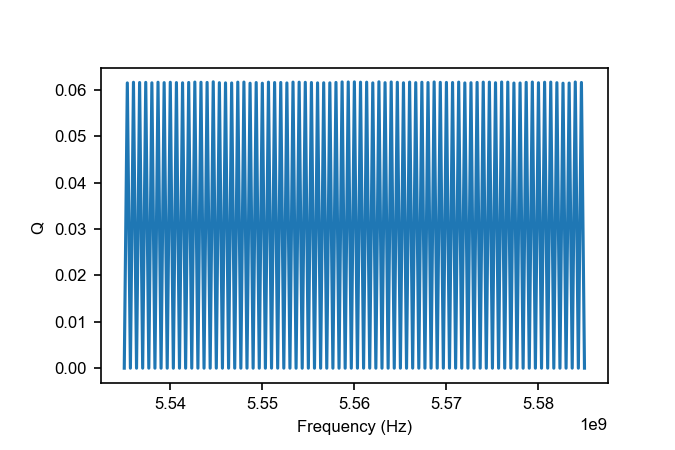

([<matplotlib.axes._subplots.AxesSubplot at 0x178025dc080>,
 [None, None])

In [29]:
plot_by_id(run_id)

Open questions are now how to best integrate this into automatic sweeping and how to best capture the data in general

It would be possible to have the context manager called inside handle buffer and store each buffer one by one but perhaps that entangles the data too much and is certainly hard to make general

## Appendix: Some benchmarking

We are adding an additional call to the acquisition function for each buffer. Lets benchmark the cost of that 

In [30]:
class Dummy:
    
    def acq(self):
        
        for i in range(100):
            pass
    def acqcallback(self):
        
        for i in range(100):
            self.callback()
        
    def callback(self):
        pass

In [31]:
a = Dummy()

In [30]:
%%timeit
a.acq()

1.59 µs ± 63 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [31]:
%%timeit
a.acqcallback()

11 µs ± 830 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


So the expense of calling a dummy function call inside the loop is approx 80 ns per loop iteration.